In [54]:
import numpy as np
from scipy.spatial import Delaunay, KDTree
import matplotlib.pyplot as plt
import math

# Step 1: Preprocess the core data
def preprocess_cores(cores):
    """
    Preprocess the core data to normalize positions, inverting the y-axis so that
    the numbering starts from the top left corner.
    :param cores: List of dictionaries with 'x', 'y', and 'radius' keys.
    :return: Normalized list of core coordinates with the y-axis inverted.
    """
    coordinates = np.array([(core['x'], core['y']) for core in cores])
    min_x, max_y = np.min(coordinates[:, 0]), np.max(coordinates[:, 1])
    normalized_inverted_coordinates = np.array([(x - min_x, max_y - y) for x, y in coordinates])
    return normalized_inverted_coordinates

import numpy as np
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans

# Step 1: Perform Delaunay triangulation and get all edges
def get_all_edges_from_triangulation(triangulation):
    edges = set()
    # For each triangle, add edges to the set, avoiding duplicates
    for simplex in triangulation.simplices:
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            edges.add(edge)
    return np.array(list(edges))


# Step 2: Delaunay triangulation
def delaunay_triangulation(coordinates):
    """
    Perform Delaunay triangulation on the coordinates.
    :param coordinates: Array of coordinates.
    :return: Delaunay object containing the triangulation.
    """
    return Delaunay(coordinates)

# # Step 2: Edge length filtering function
# def filter_edges_by_length(edges, coordinates, threshold_multiplier=1.5):
#     edge_lengths = [np.linalg.norm(coordinates[edge[0]] - coordinates[edge[1]]) for edge in edges]
#     edge_lengths = np.array(edge_lengths)
    
#     Q1, Q3 = np.percentile(edge_lengths, [25, 75])
#     IQR = Q3 - Q1
#     lower_bound = Q1 - (threshold_multiplier * IQR)
#     upper_bound = Q3 + (threshold_multiplier * IQR)

#     # We don't care about getting rid of all the short edges, just the really long ones
#     # filtered_edges = edges[(edge_lengths <= upper_bound)]
#     filtered_edges = edges[(edge_lengths >= lower_bound) & (edge_lengths <= upper_bound)]
    

#     return filtered_edges

def calculate_edge_lengths(edges, coordinates):
    return np.array([np.linalg.norm(coordinates[start] - coordinates[end]) for start, end in edges])

def calculate_mad_bounds(edge_lengths, threshold_multiplier):
    median = np.median(edge_lengths)
    mad = np.median(np.abs(edge_lengths - median))
    lower_bound = median - (threshold_multiplier * mad)
    upper_bound = median + (threshold_multiplier * mad)
    return lower_bound, upper_bound

def filter_edges_within_bounds(edges, edge_lengths, lower_bound, upper_bound):
    return [edge for edge, length in zip(edges, edge_lengths) if length <= upper_bound]

def order_edges_to_point_right(filtered_edges, coordinates):
    return [(end, start) if coordinates[start][0] > coordinates[end][0] else (start, end) for start, end in filtered_edges]

def filter_edges_by_length(edges, coordinates, threshold_multiplier=1.5):
    edge_lengths = calculate_edge_lengths(edges, coordinates)
    lower_bound, upper_bound = calculate_mad_bounds(edge_lengths, threshold_multiplier)
    filtered_edges = filter_edges_within_bounds(edges, edge_lengths, lower_bound, upper_bound)
    ordered_edges = order_edges_to_point_right(filtered_edges, coordinates)
    return ordered_edges

# Step 3: Angle filtering function
# from sklearn.cluster import KMeans

# def filter_edges_by_angle(edges, coordinates, delta=0):
#     # Calculate edge angles and adjust by δ
#     angles = np.array([np.arctan2(coordinates[edge[1]][1] - coordinates[edge[0]][1], 
#                                    coordinates[edge[1]][0] - coordinates[edge[0]][0])
#                        for edge in edges])
    
#     # Normalize angles to [0, 2*pi) and adjust by delta
#     angles = (angles + delta) % (2 * np.pi)
    
#     # Use k-means clustering to find clusters around expected angles
#     kmeans = KMeans(n_clusters=5)
#     kmeans.fit(angles.reshape(-1, 1))
    
#     # Determine which cluster corresponds to near-horizontal angles
#     # This requires examining the cluster centers and selecting the one closest to 0 + δ or π + δ
#     cluster_centers = kmeans.cluster_centers_.flatten()
#     horizontal_clusters = []
#     for expected_angle in [0, np.pi]:  # Horizontal angles adjusted by δ
#         adjusted_angle = (expected_angle + delta) % (2 * np.pi)
#         horizontal_clusters.append(np.argmin(np.abs(cluster_centers - adjusted_angle)))
    
#     # Filter edges based on their cluster label being one of the horizontal clusters
#     filtered_edge_indices = np.isin(kmeans.labels_.flatten(), horizontal_clusters)
#     filtered_edges = np.array(edges)[filtered_edge_indices]
    
#     return filtered_edges

def vector_angle(x, y):
    """
    Calculate the angle (in degrees) of a vector with respect to the x-axis.

    Parameters:
    x (float): The x-component of the vector.
    y (float): The y-component of the vector.

    Returns:
    float: The angle in degrees.
    """
    angle_radians = math.atan2(y, x)
    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

def calculate_edge_angle(start_coord, end_coord):
    """
    Calculate the angle of an edge with respect to the x-axis.

    Parameters:
    start_coord (tuple): The starting coordinate of the edge.
    end_coord (tuple): The ending coordinate of the edge.

    Returns:
    float: The angle in degrees.
    """
    dx = end_coord[0] - start_coord[0]
    dy = end_coord[1] - start_coord[1]
    angle_radians = math.atan2(dy, dx)
    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

def filter_edges_by_angle(edges, coordinates, threshold_angle, origin_angle):
    """
    Filter edges based on their angle with respect to the x-axis.

    Parameters:
    edges (list of tuples): Indices of the edges.
    coordinates (dict): Coordinate values corresponding to the edge indices.
    threshold_angle (float): The +/- threshold angle from the origin angle.
    origin_angle (float): The angle around which the threshold is calculated.

    Returns:
    list: Filtered edges that fall within the specified angle range.
    """
    filtered_edges = []
    for start, end in edges:
        edge_angle = calculate_edge_angle(coordinates[start], coordinates[end])
        if origin_angle - threshold_angle <= edge_angle <= origin_angle + threshold_angle:
            filtered_edges.append((start, end))

    return filtered_edges




In [55]:
import numpy as np

# Helper function to calculate distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Helper function to calculate the angle between two points with respect to the x-axis
def angle_with_x_axis(p1, p2):
    angle = np.arctan2(p2[1] - p1[1], p2[0] - p1[0])
    return angle if angle >= 0 else (2 * np.pi + angle)

# Helper function to check if a point is within the circular sector
def point_in_sector(V_prime, Vj, r, phi = 360, origin_angle=0):
    distance = calculate_distance(V_prime, Vj)
    if distance > r:
        return False  # The point is outside the sector's radius
    else:
        return True

    # phi_rad = np.radians(phi)
    # origin_angle_rad = np.radians(origin_angle)

    # angle_Vj_V_prime = angle_with_x_axis(Vj, V_prime)
    # start_angle = origin_angle_rad - phi_rad / 2
    # end_angle = origin_angle_rad + phi_rad / 2

    # # Normalize angles to be between 0 and 2π
    # start_angle = start_angle % (2 * np.pi)
    # end_angle = end_angle % (2 * np.pi)

    # if start_angle < end_angle:
    #     return start_angle <= angle_Vj_V_prime <= end_angle
    # else:  # The sector crosses the 0 radians line
    #     return angle_Vj_V_prime >= start_angle or angle_Vj_V_prime <= end_angle


# Helper function to check if point is within the image width threshold
def is_close_to_image_width(point, image_width, gamma):
    return abs(point[0] - image_width) < gamma


# Main traveling algorithm
def traveling_algorithm(S, image_width, d, gamma, phi=180, origin_angle=0, radius_multiplier=0.5):
    A = []  # Final list of rows of centroids
    r = radius_multiplier * d  # Radius for sector search
    imaginary_points_index = -1  # Start an index for imaginary points
    
    # Ensure S is a list of dictionaries with 'start', 'end', 'index', and 'is_imaginary' keys
    S = [{'start': np.array(v[0]), 'end': np.array(v[1]), 'index': i, 'is_imaginary': False} for i, v in enumerate(S)]
    
    while S:
        # Find the start vector with the smallest x-coordinate in the first point of the vector
        start_vector = min(S, key=lambda v: v['start'][0])
        A1 = [start_vector]  # Start with the vector with the smallest x
        
        Vj = start_vector['end']  # Current endpoint is the second element of the first vector

        # Remove the start vector from S by filtering
        S = [vector for vector in S if vector['index'] != start_vector['index']]

        # Iterative Traveling
        first_imaginary = True
        while True:
            next_vector = next((v for v in S if np.array_equal(v['start'], Vj)), None)
            if next_vector:
                Vj = next_vector['end']
                A1.append(next_vector)
                S = [vector for vector in S if vector['index'] != next_vector['index']]
                first_imaginary = True
            else:
                if not is_close_to_image_width(Vj, image_width, gamma):
                    # candidates = [v for v in S if point_in_sector(v['start'], Vj, r, phi, origin_angle)]
                    candidates = [v for v in S if point_in_sector(v['start'], Vj, r, phi, origin_angle)]

                    if candidates:
                        closest_vector = min(candidates, key=lambda v: calculate_distance(v['end'], Vj))
                        Vj = closest_vector['end']
                        A1.append(closest_vector)
                        S = [vector for vector in S if vector['index'] != closest_vector['index']]
                        first_imaginary = True

                    else:
                        # Add an imaginary point to the right of the current point
                        delta_rad = np.radians(origin_angle)  # Angle for imaginary point is 0 radians
                        Vj_prime = np.array([Vj[0] + d * np.cos(delta_rad), Vj[1] + d * np.sin(delta_rad)])
                        imaginary_vector = {'start': Vj, 'end': Vj_prime, 'index': imaginary_points_index, 'is_imaginary': True}
                        if np.abs(imaginary_vector['start'][0] - 289) < 1:
                            print("found you")
                        # If it's the first point with is_imaginary == True in A1, then set 'is_imaginary' to False. 
                        # This is because the first imaginary point will start at the last real point in the row
                        if first_imaginary:
                            imaginary_vector['is_imaginary'] = False 
                            first_imaginary = False

                        imaginary_points_index -= 1  # Decrement to keep imaginary indices unique and negative
                        A1.append(imaginary_vector)
                        Vj = Vj_prime
                        
                else:
                    
                    A1.append({'start': A1[-1]['end'], 'end': A1[-1]['end'], 'index': 0, 'is_imaginary': A1[-1]['is_imaginary']})                   

                    row = [{'point': vec['start'], 'index': vec['index'], 'is_imaginary': vec['is_imaginary']} for vec in A1]    
                    
                    # Remove duplicate points with the same 'point' key in the dictionary 
                    # Temporary dictionary to track seen points
                    seen_points = {}
                    # Filtered list for unique points
                    unique_row = []

                    for item in row:
                        point = tuple(item['point'])  # Convert numpy array to a tuple
                        if point not in seen_points:
                            seen_points[point] = True
                            unique_row.append(item)

                    A.append(unique_row)
                    if S:
                        break  # Exit the inner loop to start a new row
                    else:
                        return A  # If S is empty, we are done

        # Prepare for the next row
        A1 = []  # Clear A1 for the next row

    return A


In [56]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def visualize_delaunay_triangulation(coordinates, triangulation):
    plt.figure(figsize=(10, 6))
    plt.triplot(coordinates[:, 0], coordinates[:, 1], triangulation.simplices, color='grey', alpha=0.5)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Initial Delaunay Triangulation')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_edge_length_filtering(coordinates, edges):
    lines = [coordinates[list(edge)] for edge in edges]
    lc = LineCollection(lines, colors='blue', linewidths=1)
    
    plt.figure(figsize=(10, 6))
    plt.gca().add_collection(lc)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Edge Length Filtering')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_edge_angle_filtering(coordinates, edges):
    lines = [coordinates[list(edge)] for edge in edges]
    lc = LineCollection(lines, colors='red', linewidths=1)
    
    plt.figure(figsize=(10, 6))
    plt.gca().add_collection(lc)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Edge Angle Filtering')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_traveling_algorithm(coordinates, path):
    path_coords = coordinates[path]
    
    plt.figure(figsize=(10, 6))
    plt.plot(path_coords[:, 0], path_coords[:, 1], 'o-', color='green')
    plt.title('Traveling Algorithm Path')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

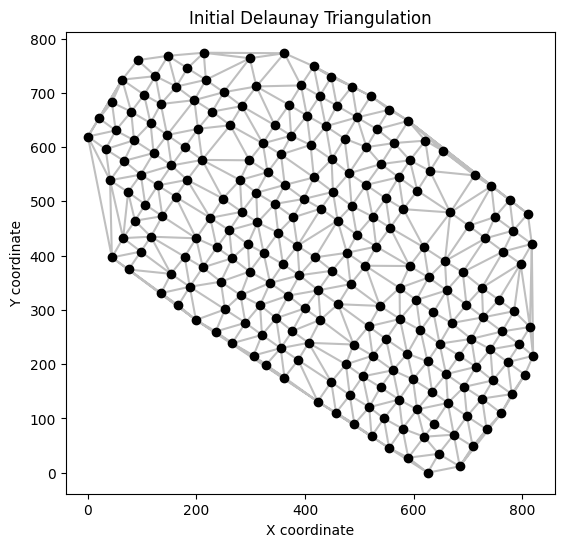

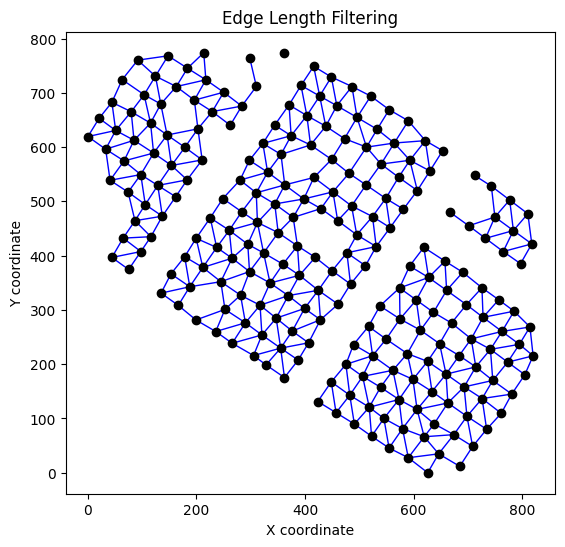

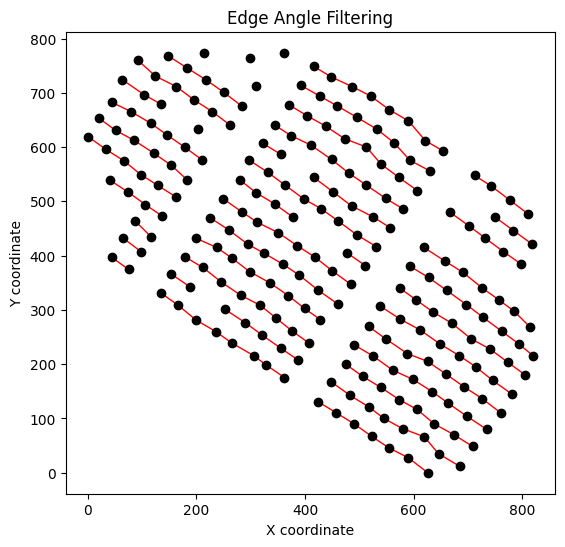

In [57]:
import pandas as pd
# Main workflow
data = pd.read_json('./augmented_labels/158867_aug_5.json')
data = data.to_dict('records')

# Convert the data to the required format if necessary
cores = data  # Assuming 'data' is already in the correct format

# Perform initial Delaunay triangulation
# Example usage in the pipeline
normalized_coordinates = preprocess_cores(data)
triangulation = Delaunay(normalized_coordinates)
visualize_delaunay_triangulation(normalized_coordinates, triangulation)


all_edges = get_all_edges_from_triangulation(triangulation)
length_filtered_edges = filter_edges_by_length(all_edges, normalized_coordinates, 2)
angle_filtered_edges = filter_edges_by_angle(length_filtered_edges, normalized_coordinates, 25, -35)

# Example usage:
# Assume `filtered_edges` is a list of tuples (or sets) representing the remaining edges after filtering,
# `core_to_core_distance` is the average distance between cores,
# and `delta` is the angular tolerance in degrees for horizontal traversal.


# The `rows` variable contains lists of core indices, where each list represents a row in the grid.

visualize_edge_length_filtering(normalized_coordinates, length_filtered_edges)
visualize_edge_angle_filtering(normalized_coordinates, angle_filtered_edges)

# visualize_traveling_algorithm(normalized_coordinates, path)



In [58]:
length_filtered_edges

[(57, 55),
 (177, 181),
 (176, 213),
 (55, 66),
 (96, 104),
 (149, 147),
 (99, 109),
 (159, 160),
 (64, 151),
 (70, 82),
 (40, 50),
 (100, 101),
 (46, 130),
 (133, 132),
 (193, 192),
 (126, 77),
 (73, 74),
 (35, 227),
 (226, 225),
 (11, 144),
 (167, 166),
 (15, 16),
 (227, 226),
 (169, 94),
 (99, 96),
 (59, 68),
 (30, 18),
 (191, 188),
 (200, 199),
 (199, 209),
 (152, 86),
 (129, 65),
 (227, 54),
 (214, 180),
 (141, 140),
 (7, 142),
 (222, 35),
 (173, 174),
 (134, 125),
 (94, 155),
 (206, 207),
 (55, 56),
 (88, 90),
 (147, 148),
 (128, 45),
 (107, 112),
 (207, 208),
 (58, 67),
 (64, 150),
 (21, 36),
 (189, 51),
 (80, 85),
 (46, 129),
 (150, 132),
 (184, 188),
 (204, 16),
 (182, 181),
 (201, 194),
 (45, 132),
 (170, 108),
 (21, 22),
 (195, 191),
 (119, 76),
 (131, 129),
 (205, 206),
 (174, 67),
 (131, 63),
 (147, 146),
 (112, 154),
 (45, 32),
 (179, 180),
 (117, 72),
 (54, 167),
 (89, 88),
 (156, 108),
 (121, 109),
 (143, 139),
 (168, 66),
 (50, 62),
 (61, 62),
 (35, 21),
 (61, 71),
 (1

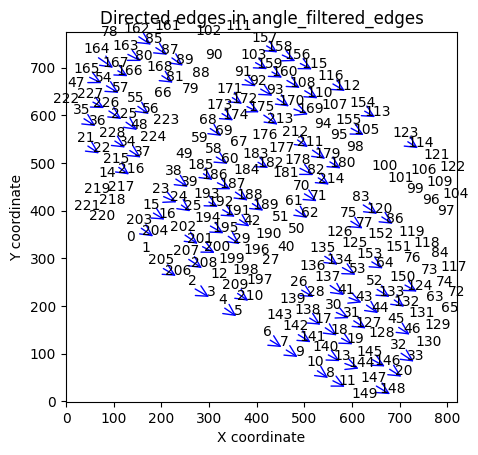

In [59]:
# # Sort the edges to ensure the arrow goes from left to right
# sorted_edges = []
# for edge in angle_filtered_edges:
#     start, end = edge
#     if normalized_coordinates[start][0] > normalized_coordinates[end][0]:
#         # Swap the start and end points
#         sorted_edges.append((end, start))
#     else:
#         sorted_edges.append((start, end))

def is_point_in_list(point, point_list, tol=1e-5):
    return any(np.allclose(point, p, atol=tol) for p in point_list)

traveling_algorithm_input = [normalized_coordinates[list(edge)] for edge in sorted_edges]

isolated_points = [point for point in normalized_coordinates if not is_point_in_list(point, np.array(traveling_algorithm_input).reshape(-1, 2))]

isolated_points_input = [[point, point] for point in isolated_points]
traveling_algorithm_input += isolated_points_input

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the arrows using FancyArrowPatch
for (start, end) in traveling_algorithm_input:
    
    # Create an arrow patch
    arrow = FancyArrowPatch(start, end, arrowstyle='->', mutation_scale=20, color='b')

    # Add it to the axis
    ax.add_patch(arrow)

# Label the points with their indices
for i, coord in enumerate(normalized_coordinates):
    ax.text(coord[0], coord[1], str(i), ha='center', va='bottom')

# Set the plot title and labels
ax.set_title('Directed edges in angle_filtered_edges')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')

# Set the same scale for both axes and set the limit
ax.set_aspect('equal')
ax.set_xlim([min(x[0] for x in normalized_coordinates)-1, max(x[0] for x in normalized_coordinates)+1])
ax.set_ylim([min(y[1] for y in normalized_coordinates)-1, max(y[1] for y in normalized_coordinates)+1])

# Show the plot
plt.show()


In [60]:
def calculate_angle(p1, p2):
    """Calculate the angle between two points."""
    delta_y = p2[1] - p1[1]
    delta_x = p2[0] - p1[0]
    return np.arctan2(delta_y, delta_x)

# Calculate angles between pairs of vertices
angles = []
for pair in traveling_algorithm_input:
    # Check if pair contains two points
    if len(pair) == 2:
        angle = calculate_angle(pair[0], pair[1])
        angles.append(angle)

# Convert angles to degrees and calculate average
angles_degrees = np.rad2deg(angles)
average_angle = np.median(angles_degrees)

angles_degrees

array([-29.4032087 , -34.19524275, -28.83217333, -33.08039968,
       -29.2235987 , -30.5895948 , -28.24754281, -31.34469509,
       -34.66292772, -30.66379259, -33.19859607, -33.2789586 ,
       -30.30306842, -31.22941199, -34.93963032, -29.91814465,
       -32.55569079, -34.4111806 , -28.6183841 , -33.23425142,
       -28.0548243 , -30.09337714, -29.11088583, -34.52678199,
       -32.63612829, -34.57426112, -32.16215014, -33.14083825,
       -30.15558449, -26.58177574, -24.70246027, -33.95818558,
       -34.82116175, -26.06809364, -34.44144778, -24.01843163,
       -34.97185371, -24.499442  , -27.21263484, -29.4032087 ,
       -31.65778367, -34.23596469, -34.49628438, -32.60490282,
       -32.18062257, -30.4245762 , -31.12018629, -30.13460019,
       -32.31723118, -28.76008705, -34.44144778, -32.807727  ,
       -30.68305318, -26.82623383, -34.37947292, -21.06700731,
       -25.56788961, -34.52452521, -31.26507209, -31.69348797,
       -28.69662937, -33.52093033, -31.05210479, -34.33

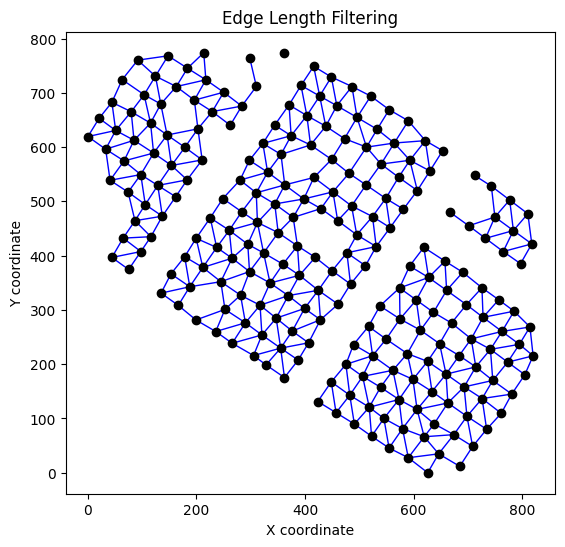

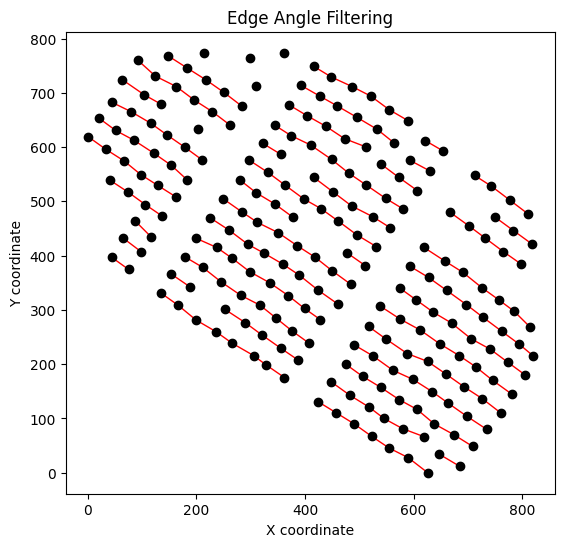

In [61]:
length_filtered_edges = filter_edges_by_length(all_edges, normalized_coordinates,2)
angle_filtered_edges = filter_edges_by_angle(length_filtered_edges, normalized_coordinates, 20, average_angle)

# Example usage:
# Assume `filtered_edges` is a list of tuples (or sets) representing the remaining edges after filtering,
# `core_to_core_distance` is the average distance between cores,
# and `delta` is the angular tolerance in degrees for horizontal traversal.


# The `rows` variable contains lists of core indices, where each list represents a row in the grid.

visualize_edge_length_filtering(normalized_coordinates, length_filtered_edges)
visualize_edge_angle_filtering(normalized_coordinates, angle_filtered_edges)

# visualize_traveling_algorithm(normalized_coordinates, path)



In [62]:
import matplotlib.pyplot as plt

def plot_rows_with_labels(rows):
    """
    Plots each row with labels indicating row and column numbers and distinguishes between real and imaginary points,
    with better label management to avoid overlapping.

    Parameters:
    rows (list of list of dicts): List where each sublist represents a row of points (centroids),
                                  and each point is a dictionary containing 'point', 'index', and 'is_imaginary'.
    """
    # Create a larger plot to better accommodate labels
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Define colors and markers
    real_point_color = 'blue'
    imaginary_point_color = 'red'

    # Plot each point and add a label
    for row_idx, row in enumerate(rows):
        for col_idx, point_info in enumerate(row):
            x, y = point_info['point']
            is_imaginary = point_info['is_imaginary']
            color = imaginary_point_color if is_imaginary else real_point_color
            ax.plot(x, y, 'o', color=color)  # Use 'o' for both real and imaginary for uniformity
            
            # Offset for text label to reduce overlap, adjust as needed
            offset = 5
            ha = 'right' if col_idx % 2 == 0 else 'left'
            va = 'bottom' if row_idx % 2 == 0 else 'top'
            ax.text(x + offset if ha == 'right' else x - offset, 
                    y + offset if va == 'bottom' else y - offset, 
                    f'R{row_idx}C{col_idx}',
                    fontsize=8, ha=ha, va=va, color=color)

    # Set plot labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Rows with Labels')

    # Show grid
    ax.grid(True)

    # Create a legend for real and imaginary points
    real_legend = plt.Line2D([0], [0], marker='o', color=real_point_color, label='Real Points', markersize=5)
    imaginary_legend = plt.Line2D([0], [0], marker='o', color=imaginary_point_color, label='Imaginary Points', markersize=5)
    ax.legend(handles=[real_legend, imaginary_legend])

    # Adjust axis limits to make sure all points are visible
    all_x = [point_info['point'][0] for row in rows for point_info in row]
    all_y = [point_info['point'][1] for row in rows for point_info in row]
    ax.set_xlim([min(all_x) - 10, max(all_x) + 10])
    ax.set_ylim([min(all_y) - 10, max(all_y) + 10])

    # Show the plot
    plt.show()


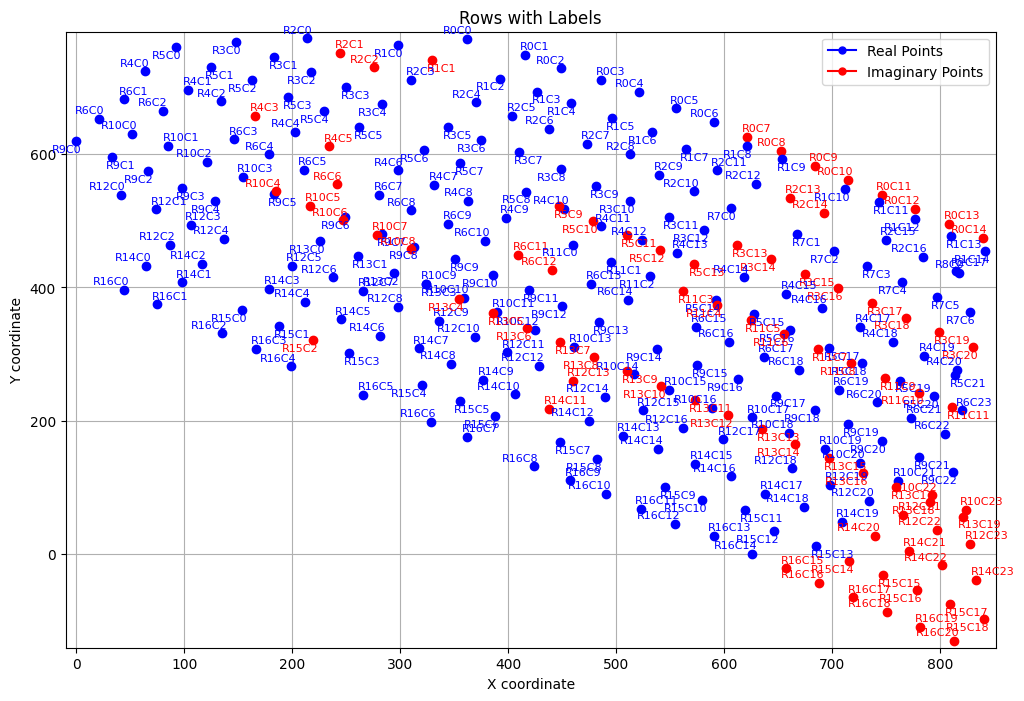

In [63]:
import numpy as np
from itertools import combinations

average_distances = []
for edge in traveling_algorithm_input:
    start, end = edge
    distance = np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
    average_distances.append(distance)

average_distance = np.median(average_distances)

def calculate_Y(centers, d):
    """Calculate Y based on the maximum X value of the core + 1.5 * d."""
    max_x = max(centers, key=lambda x: x[0])[0]
    return max_x + 0.5 * d


# Calculate the average core-to-core distance
d = average_distance

# Calculate Y
Y = calculate_Y(normalized_coordinates, d)

rows = traveling_algorithm(traveling_algorithm_input, Y, d, 0.75 * d, 360, -35, 1)
sorted_rows = sorted(rows, key=lambda row: -np.median([point['point'][1] for point in row]))

# Plot the sorted rows
plot_rows_with_labels(sorted_rows)
